In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.layers import UpSampling2D  # alternativa
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.10.0'

# Carregando os dados

In [2]:
from tensorflow.keras.datasets import fashion_mnist   

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() 

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

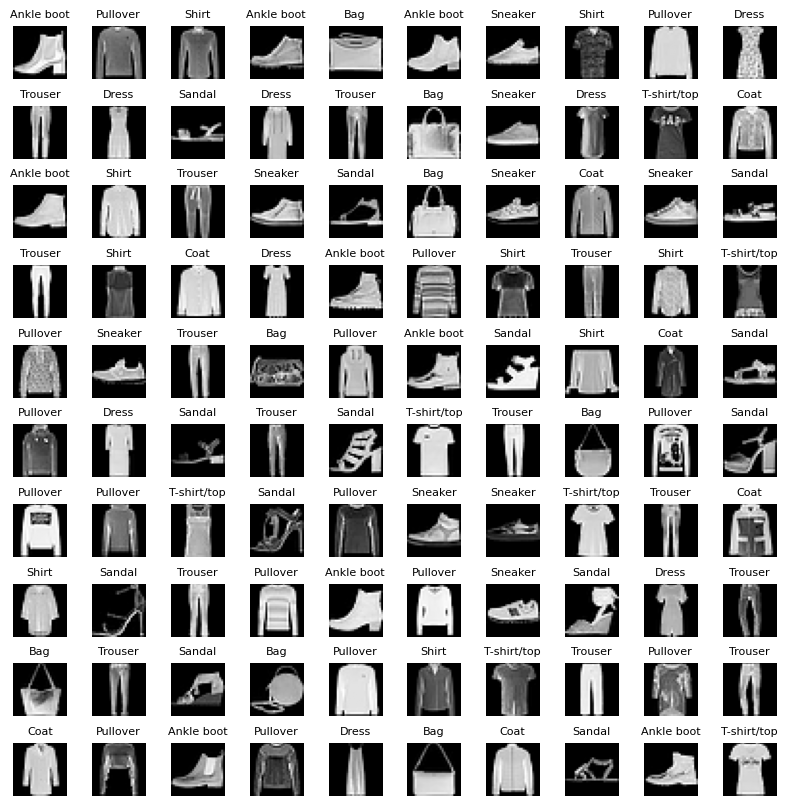

In [4]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
largura = 10
altura = 10
figure, axes = plt.subplots(altura, largura, figsize=(10, 10))
axes = axes.ravel()# (10, 10) -> [100]
for i in range(0, altura * largura):
    indice = np.random.randint(0, x_train.shape[0])
    axes[i].imshow(x_train[indice], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(classes[y_train[indice]], fontsize=8)
plt.subplots_adjust(hspace=0.5, wspace=0.2)


In [5]:
x_train = x_train / 255
x_test = x_test / 255

x_train.max(), x_train.min()


(1.0, 0.0)

In [6]:
def resize_data_with_cannal(data):
    #para convulucao precisamos informar o numero de canais das imgs
    return data.reshape(data.shape[0], 28, 28, 1)

x_train = resize_data_with_cannal(x_train)
x_test = resize_data_with_cannal(x_test)
x_train.shape, x_test.shape


((60000, 28, 28, 1), (10000, 28, 28, 1))

# Construindo o autoencoder convulucional

In [7]:
autoencoder = Sequential()

#padding = valid -> perde alguns pixels da borda e não utiliza todos os pixels para o calculo de convulucao
#padding = same -> utiliza todos os pixels da imagem para o calculo

#ENCONDER 
autoencoder.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=(28, 28, 1)))
autoencoder.add(MaxPooling2D((2,2), padding='same'))

autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2,2), padding='same'))

#strides = quantidade em que os filtros se movem no calculo da convulucao, ou seja, se for 2, ele vai pulando 2 pixels na convolucao
autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', strides=(2,2)))

autoencoder.add(Flatten())

#DECODER
autoencoder.add(Reshape((4, 4, 8)))

autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D(size=(2,2)))
#upsampling para expandir os pixels que foram reduzidos com o Maxpooling
#Embora não recupere todos os dados perdidos na diminuição com o Maxpooling, ele cria dados fakes (o autoencoder consegue contornar isso)

autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D(size=(2,2)))

autoencoder.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu',))
autoencoder.add(UpSampling2D(size=(2,2)))

# Camada final para reconstruir a imagem original (28, 28, 1)
autoencoder.add(Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same'))

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 flatten (Flatten)           (None, 128)               0

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, validation_data=(x_test, None))

In [11]:
enconder =  Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten').output)

In [ ]:
imagens_test_codificadas = enconder.predict(x_test)
imagens_test_codificadas[0]


313/313 [==============================] - 1s 2ms/step


4.6086035

In [26]:
imagens_test_decodificadas = autoencoder.predict(x_test)
imagens_test_decodificadas.shape


313/313 [==============================] - 1s 3ms/step


(10000, 28, 28, 1)

## Comparando as imagens

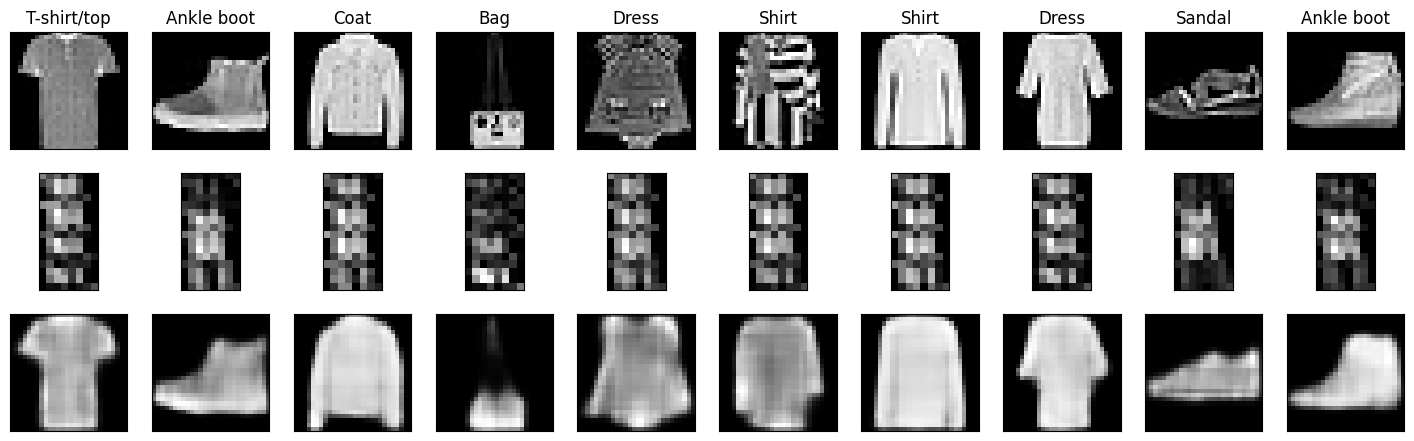

In [37]:
qtde_imgs = 10
index_teste = np.random.randint(0, x_test.shape[0], qtde_imgs)
plt.figure(figsize=(18, 18))
for i, img_index in enumerate(index_teste):
    #imagens originais
    ax = plt.subplot(10, qtde_imgs, i + 1)
    plt.imshow(x_test[img_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(classes[y_test[img_index]])

    #imagens codificadas
    ax = plt.subplot(10, qtde_imgs, i + 1 + qtde_imgs)
    plt.imshow(imagens_test_codificadas[img_index].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    #imagens decodificadas
    ax = plt.subplot(10, qtde_imgs, i + 1 + qtde_imgs * 2)
    plt.imshow(imagens_test_decodificadas[img_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [27]:
x_test.shape

(10000, 28, 28, 1)